# Lowest Common Ancestor

In this tutorial, we will explore the python implementation of the lowest common ancestor algorithm [^1] in NetworkX at [`networkx/algorithms/lowest_common_ancestor.py`](https://github.com/networkx/networkx/blob/main/networkx/algorithms/lowest_common_ancestors.py). This notebook expects readers to be familiar with the NetworkX API. If you are new to NetworkX, you can go through the [introductory tutorial](https://networkx.org/documentation/latest/tutorial.html).

## Import packages

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from itertools import chain, count, combinations_with_replacement

## Definitions

Before diving into the algorithm, let's first remember the concepts of an ancestor node and a descendant node.

- **Ancestor:**
  Given a rooted tree, any node $u$ which is on the path from root node to $v$ is an ancestor of $u$.

- **Descendant:** A descendant of a node is either a child of the node or a child of some descendant of the node.

- **Lowest Common Ancestor:** For two of nodes $u$ and $v$ in a tree, the lowest common ancestor is the lowest (i.e. deepest) node which is an ancestor of both $u$ and $v$.


## Example

It is always a good idea to learn concepts with an example. Consider the following evolutionary tree. We will draw a directed version of it and define the ancestor/descendant relationships.

![image:evolutionary tree](images/evol_tree.png)

Let's first draw the tree using NetworkX.

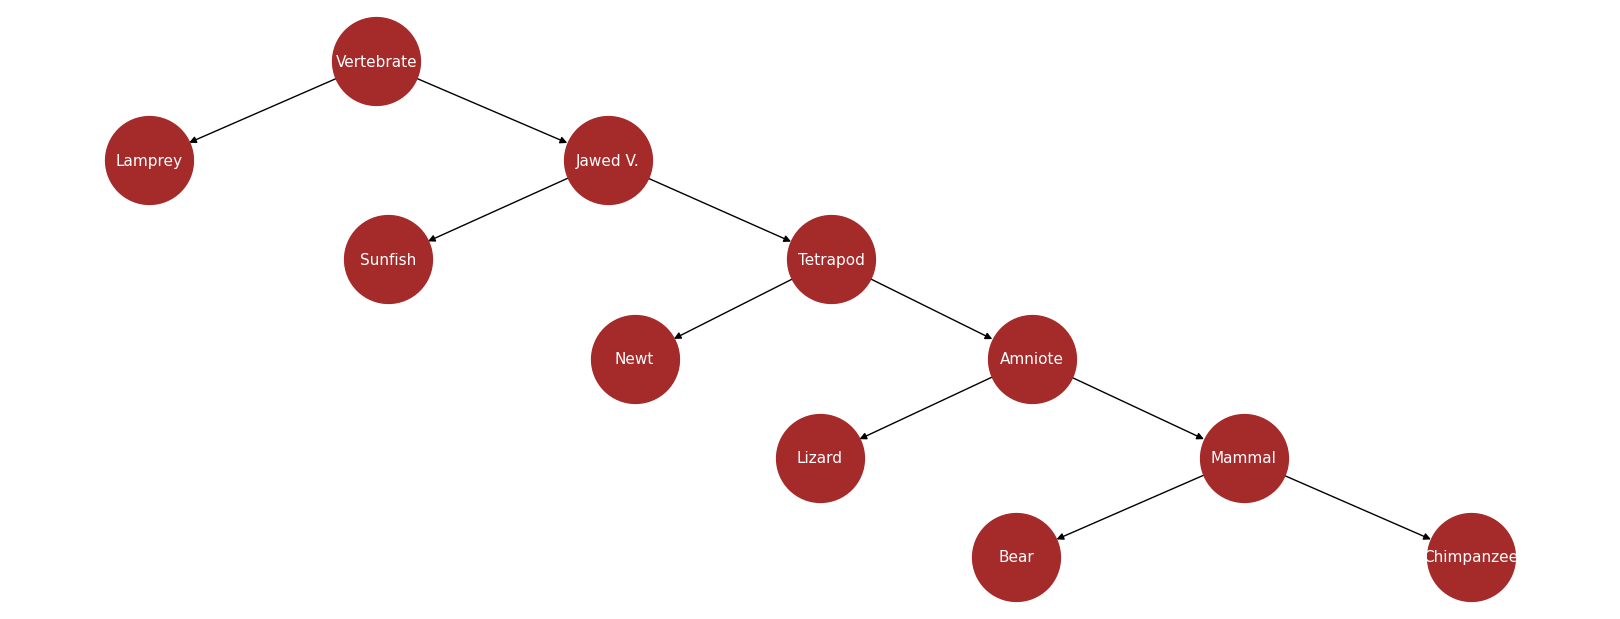

In [2]:
T = nx.DiGraph()
T.add_edges_from(
    [
        ("Vertebrate", "Lamprey"),
        ("Vertebrate", "Jawed V."),
        ("Jawed V.", "Sunfish"),
        ("Jawed V.", "Tetrapod"),
        ("Tetrapod", "Newt"),
        ("Tetrapod", "Amniote"),
        ("Amniote", "Lizard"),
        ("Amniote", "Mammal"),
        ("Mammal", "Bear"),
        ("Mammal", "Chimpanzee"),
    ]
)
pos = graphviz_layout(T, prog="dot")
plt.figure(3, figsize=(16, 6))
nx.draw(
    T,
    pos,
    with_labels=True,
    node_size=4000,
    node_color="brown",
    font_size=11,
    font_color="White",
)
plt.show()

Consider the tree above and observe the following relationships:

- Ancestors of node Mammal:
  - For this, we will follow the path from root to node Mammal.
  - Nodes Vertebrate, Jawed Vertebrate, Tetrapod and Amniote -which are on this path- are ancestors of Mammal.
- Descendants of node Mammal:
  - Bear and Chimpanzee are the child of Mammal. Thus, they are its descendants.
- Lowest Common Ancestor of Mammal and Newt:
  - Ancestors of Mammal are Vertebrate, Jawed Vertebrate, Tetrapod and Amniote.
  - Ancestors of Newt are Vertebrate, Jawed Vertebrate, and Tetrapod.
  - Among the common ancestors, the lowest (i.e. farthest away from the root) one is Tetrapod.

_Note that, in terms of lowest common ancestor algorithms, every node is considered as an ancestor itself._

## NetworkX's Implementation of Lowest Common Ancestor Algorithm

NetworkX uses a naive algorithm to find the lowest common ancestor of given pairs of nodes. In this section, we will introduce it step by step.

### Step 1: Check if the type of input graph is DAG.

Lowest common ancestor algorithms under NetworkX are implemented only for directed acyclic graphs with at least one node. For this, the source code first checks if the input graph is a valid one or not.

```python
def naive_all_pairs_lowest_common_ancestor(G, pairs=None):
    if not nx.is_directed_acyclic_graph(G):
        raise nx.NetworkXError("LCA only defined on directed acyclic graphs.")
    elif len(G) == 0:
        raise nx.NetworkXPointlessConcept("LCA meaningless on null graphs.")
```

If the "pairs" argument is not set, we consider all unordered pairs of nodes in G by default, e.g. we do not get both (b, a) and (a, b) but only one of them. If pairs are already specified, we check if every node in pairs exists in the input graph.

```python
if pairs is None:
    from itertools import combinations_with_replacement
    pairs = combinations_with_replacement(G, 2)
else:
  pairs = dict.fromkeys(pairs)
  nodeset = set(G)
  for pair in pairs:
      if set(pair) - nodeset:
          raise nx.NodeNotFound(
              f"Node(s) {set(pair) - nodeset} from pair {pair} not in G."
          )
```

### Step 2: Find ancestors of all nodes in G.

Once the input validation is done, we find all ancestors of every node in the pairs and store these information in a cache.

```python
ancestor_cache = {}

for v, w in pairs:
    if v not in ancestor_cache:
        ancestor_cache[v] = nx.ancestors(G, v)
        ancestor_cache[v].add(v)
    if w not in ancestor_cache:
        ancestor_cache[w] = nx.ancestors(G, w)
        ancestor_cache[w].add(w)
```

### Step 3: Find common ancestors

For each pair (v, w), we determine nodes that appear in both ancestor lists of $v$ and $w$. (i.e. find all common ancestors)

```python
common_ancestors = ancestor_cache[v] & ancestor_cache[w]
```

### Step 4: Find a node in common ancestors which is located at the lowest level in the graph.

We start with an arbitrary node $v$ from the set of common ancestors. We follow the arbitrary outgoing edges remaining in the set of common ancestors, until reaching a node with no outgoing edge to another of the common ancestors.

```python
v = next(iter(common_ancestors))
while True:
  successor = None
  for w in G.successors(v):
    if w in common_ancestors:
      successor = w
      break
  if successor is None:
      return v
  v = successor
```

We can see the result of our algorithm for a simple directed acyclic graph. Assume that our graph G is as follows and we wish to find lowest common ancestors for all pairs. For this, we need to call the `all_pairs_lowest_common_ancestor`
method.

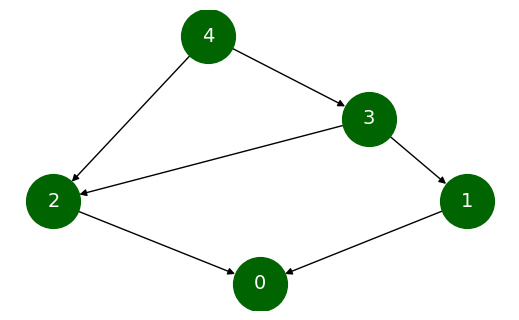

In [3]:
# Generating and visualizing our DAG
G = nx.DiGraph()
G.add_edges_from([(1, 0), (2, 0), (3, 2), (3, 1), (4, 2), (4, 3)])
pairs = combinations_with_replacement(G, 2)

pos = graphviz_layout(G, prog="dot")
plt.figure(3, figsize=(5, 3))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1500,
    node_color="darkgreen",
    font_size=14,
    font_color="White",
)
plt.show()

In [4]:
dict(nx.all_pairs_lowest_common_ancestor(G))

{(1, 1): 1,
 (1, 0): 1,
 (1, 2): 3,
 (1, 3): 3,
 (1, 4): 4,
 (0, 0): 0,
 (0, 2): 2,
 (0, 3): 3,
 (0, 4): 4,
 (2, 2): 2,
 (2, 3): 3,
 (2, 4): 4,
 (3, 3): 3,
 (3, 4): 4,
 (4, 4): 4}

## Time & Space Complexity

Naive implementation of lowest common ancestor algorithm finds all ancestors of all nodes in the given pairs. Let the number of nodes given in the pairs be P. In the worst case, finding ancestors of a single node will take O(|V|) times where |V| is the number of nodes. Thus, constructing the ancestor cache of a graph will take O(|V|\*P) times. This step will dominate the others and determine the worst-case running time of the algorithm.

The space complexity of the algorithm will also be determined by the ancestor cache. For each node in the given pairs, there might be O(|V|) ancestors. Thus, space complexity is also O(|V|\*P).

## References
[^1]: [Wikipedia, Lowest common ancestor](https://en.wikipedia.org/wiki/Lowest_common_ancestor)